# <span style="color:#00BDFF">pls using sklearn </span>

In [1]:
# --------------------------------------------------------------------------

# ----------------- pls multivariate calibration with sklearn

# -------------------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os
import requests
from io import StringIO

# --- data handling modules

import numpy as np
import pandas as pd

# --- visualization modules

import matplotlib.pyplot as plt
import matplotlib as mtply


# --- my modules

methods_dir = '../modules/'  
sys.path.insert(0, methods_dir)
from model_building import *

# <span style="color:#00BDFF">input data</span>

In [2]:


data_url = "https://gitlab.com/vfonsecad/chemometrics_data/-/raw/main/data/nir_sugarcane/sugarcane_all.csv"
data_pd_raw = pd.read_csv(data_url, sep = ";", index_col = 0)
data_pd = data_pd_raw.dropna(axis=0, how='any') # dropping na for this analysis
print(data_pd)
print(data_pd.columns)


       Sample instrument   wavelength  absorbance     TS    CP    ADF  IVOMD
0         100       F750   450.000000    -0.01790   4.76  7.03  40.69  36.77
60        100       F750   453.000000    -0.02020   4.76  7.03  40.69  36.77
120       100       F750   456.000000    -0.02210   4.76  7.03  40.69  36.77
180       100       F750   459.000000    -0.02370   4.76  7.03  40.69  36.77
240       100       F750   462.000000    -0.02490   4.76  7.03  40.69  36.77
...       ...        ...          ...         ...    ...   ...    ...    ...
15119     159   Tellspec  1689.692017     0.52740  38.24  1.74  29.55  51.90
15179     159   Tellspec  1692.622559     0.53912  38.24  1.74  29.55  51.90
15239     159   Tellspec  1695.548828     0.54147  38.24  1.74  29.55  51.90
15299     159   Tellspec  1697.497314     0.54928  38.24  1.74  29.55  51.90
15359     159   Tellspec  1700.416504     0.55918  38.24  1.74  29.55  51.90

[99579 rows x 8 columns]
Index(['Sample', 'instrument', 'wavelength', 'abso

In [3]:
# data

y_names = ["TS"]

data_F750 = data_pd.loc[(data_pd["instrument"]=="F750"),["Sample","wavelength","absorbance"] + y_names]
xF750 = data_F750.pivot(index = "Sample",columns= "wavelength", values = "absorbance")
xF750.reset_index(inplace=True)
xyF750 = data_F750.loc[:,["Sample"] + y_names].drop_duplicates().merge(xF750, on = "Sample", how = "left")
wv_range = data_pd.loc[(data_pd["instrument"]=="F750"),"wavelength"].unique()
print(xyF750.columns)

Ntotal = xyF750.shape[0]
cal_samples = np.random.choice(Ntotal,45, replace=False) 
test_samples = np.array([ii for ii in range(Ntotal) if ii not in cal_samples])

xcal_pls = np.array(xyF750.iloc[cal_samples,2:])
ycal_pls = np.array(xyF750.iloc[cal_samples].loc[:,y_names])
xtest_pls = np.array(xyF750.iloc[test_samples,2:])
ytest_pls = np.array(xyF750.iloc[test_samples].loc[:,y_names])




Index(['Sample',     'TS',    450.0,    453.0,    456.0,    459.0,    462.0,
          465.0,    468.0,    471.0,
       ...
         1113.0,   1116.0,   1119.0,   1122.0,   1125.0,   1128.0,   1131.0,
         1134.0,   1137.0,   1140.0],
      dtype='object', length=233)


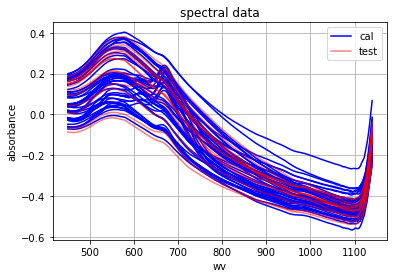

In [4]:
# visualize data

plt.plot(wv_range,xcal_pls[0], c = "blue", label = "cal")
plt.plot(wv_range,xcal_pls.T, c = "blue")
plt.plot(wv_range,xtest_pls[0], c = "red", alpha = 0.5, label = "test")
plt.plot(wv_range,xtest_pls.T, c = "red", alpha = 0.5)
plt.xlabel("wv")
plt.ylabel("absorbance")
plt.title("spectral data")
plt.legend()
plt.grid()
plt.show()

# <span style="color:#00BDFF">process: pls model building</span>

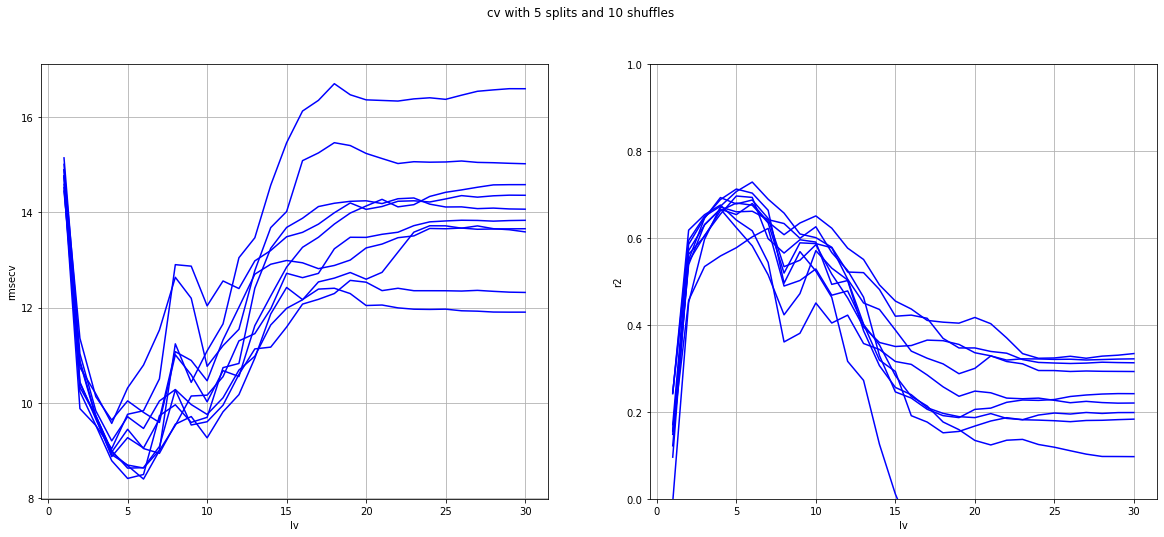

In [5]:
# pls cv

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


total_lv = 30
n_splits_cv = 5
n_shuffles = 10

parameters = {'n_components': list(range(1,total_lv+1))}
pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}


fig, axs = plt.subplots(1,2,figsize = (20,8))

for nn in range(n_shuffles):

    pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
    my_pls = PLSRegression(scale=False)
    my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
    my_pls_cv.fit(xcal_pls, ycal_pls)

    axs[0].plot(my_pls_cv.cv_results_["param_n_components"],-1*my_pls_cv.cv_results_["mean_test_rmse"], c = "blue")
    axs[1].plot(my_pls_cv.cv_results_["param_n_components"],my_pls_cv.cv_results_["mean_test_r2"], c = "blue")

axs[0].set_xlabel("lv")
axs[0].set_ylabel("rmsecv")
axs[0].grid()

axs[1].set_xlabel("lv")
axs[1].set_ylabel("r2")
axs[1].set_ylim([0,1])
axs[1].grid()


fig.suptitle("cv with {} splits and {} shuffles".format(n_splits_cv, n_shuffles))
plt.show()


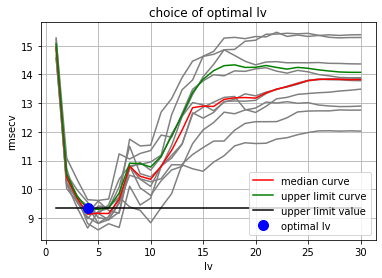

4

In [20]:
# automatic selection of lv

plsr_univariate_optimal_lv(xcal_pls, ycal_pls, total_lv=30, n_splits_cv=5, n_shuffles=10,quantile_limit = 0.71, cv_plot = True)

In [14]:
# choose model

chosen_lv = 4

my_pls = PLSRegression(n_components = chosen_lv,scale=False)
my_pls.fit(xcal_pls, ycal_pls)

# deliver model

B = my_pls.coef_
beta = my_pls.y_mean_ - (my_pls.x_mean_.dot(B))




In [15]:
# use model

from sklearn.metrics import mean_squared_error, r2_score


ycal_pls_pred = xcal_pls.dot(B) + beta
rmsec = np.sqrt(mean_squared_error(ycal_pls, ycal_pls_pred))
r2c = r2_score(ycal_pls, ycal_pls_pred)


ytest_pls_pred = xtest_pls.dot(B) + beta
rmsep = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
r2p = r2_score(ytest_pls, ytest_pls_pred)



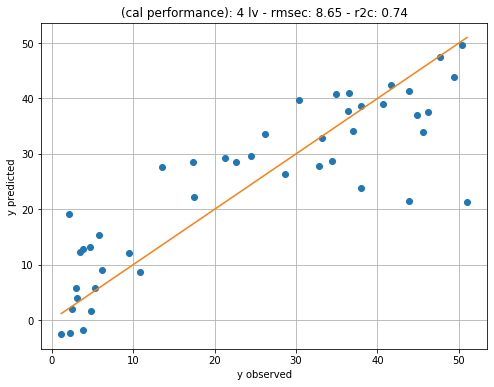

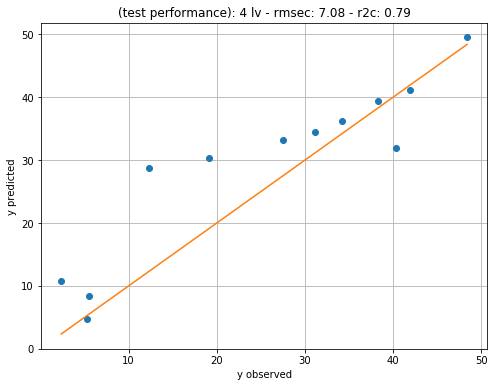

In [16]:
# model performance

cal_title = "(cal performance): {:d} lv - rmsec: {:.2f} - r2c: {:.2f}".format(chosen_lv, rmsec, r2c) 

plt.subplots(figsize = (8,6))
plt.plot(ycal_pls,ycal_pls_pred,'o')
plt.plot([np.amin(ycal_pls),np.amax(ycal_pls)],[np.amin(ycal_pls),np.amax(ycal_pls)])
plt.grid()
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.title(cal_title) 
plt.show()

test_title = "(test performance): {:d} lv - rmsec: {:.2f} - r2c: {:.2f}".format(chosen_lv, rmsep, r2p) 

plt.subplots(figsize = (8,6))
plt.plot(ytest_pls,ytest_pls_pred,'o')
plt.plot([np.amin(ytest_pls),np.amax(ytest_pls)],[np.amin(ytest_pls),np.amax(ytest_pls)])
plt.grid()
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.title(test_title)
plt.show()




# <span style="color:#00BDFF">output: model parameters</span>

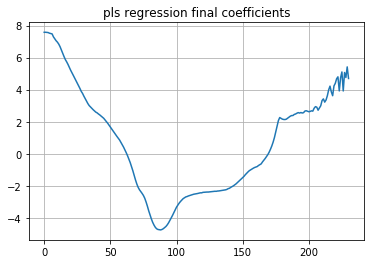

array([31.73897531])

In [17]:
# final model
plt.plot(B)
plt.grid()
plt.title("pls regression final coefficients")
plt.show()
beta